# Image Segmentation and Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Brain_MRI

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Brain_MRI


In [3]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [4]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [7]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [8]:
# check the number of healthy and cancerous brain images
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# TASK #3: PERFORM DATA VISUALIZATION

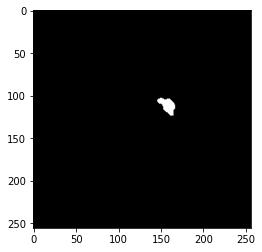

In [9]:
# plot the mask
plt.imshow(cv2.imread(brain_df['mask_path'].loc[brain_df['mask'] ==1].values[0]))

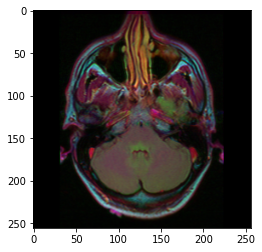

In [10]:
# plot the brain image to corresponding mask
plt.imshow(cv2.imread(brain_df['image_path'].loc[brain_df['mask'] ==1].values[0]))

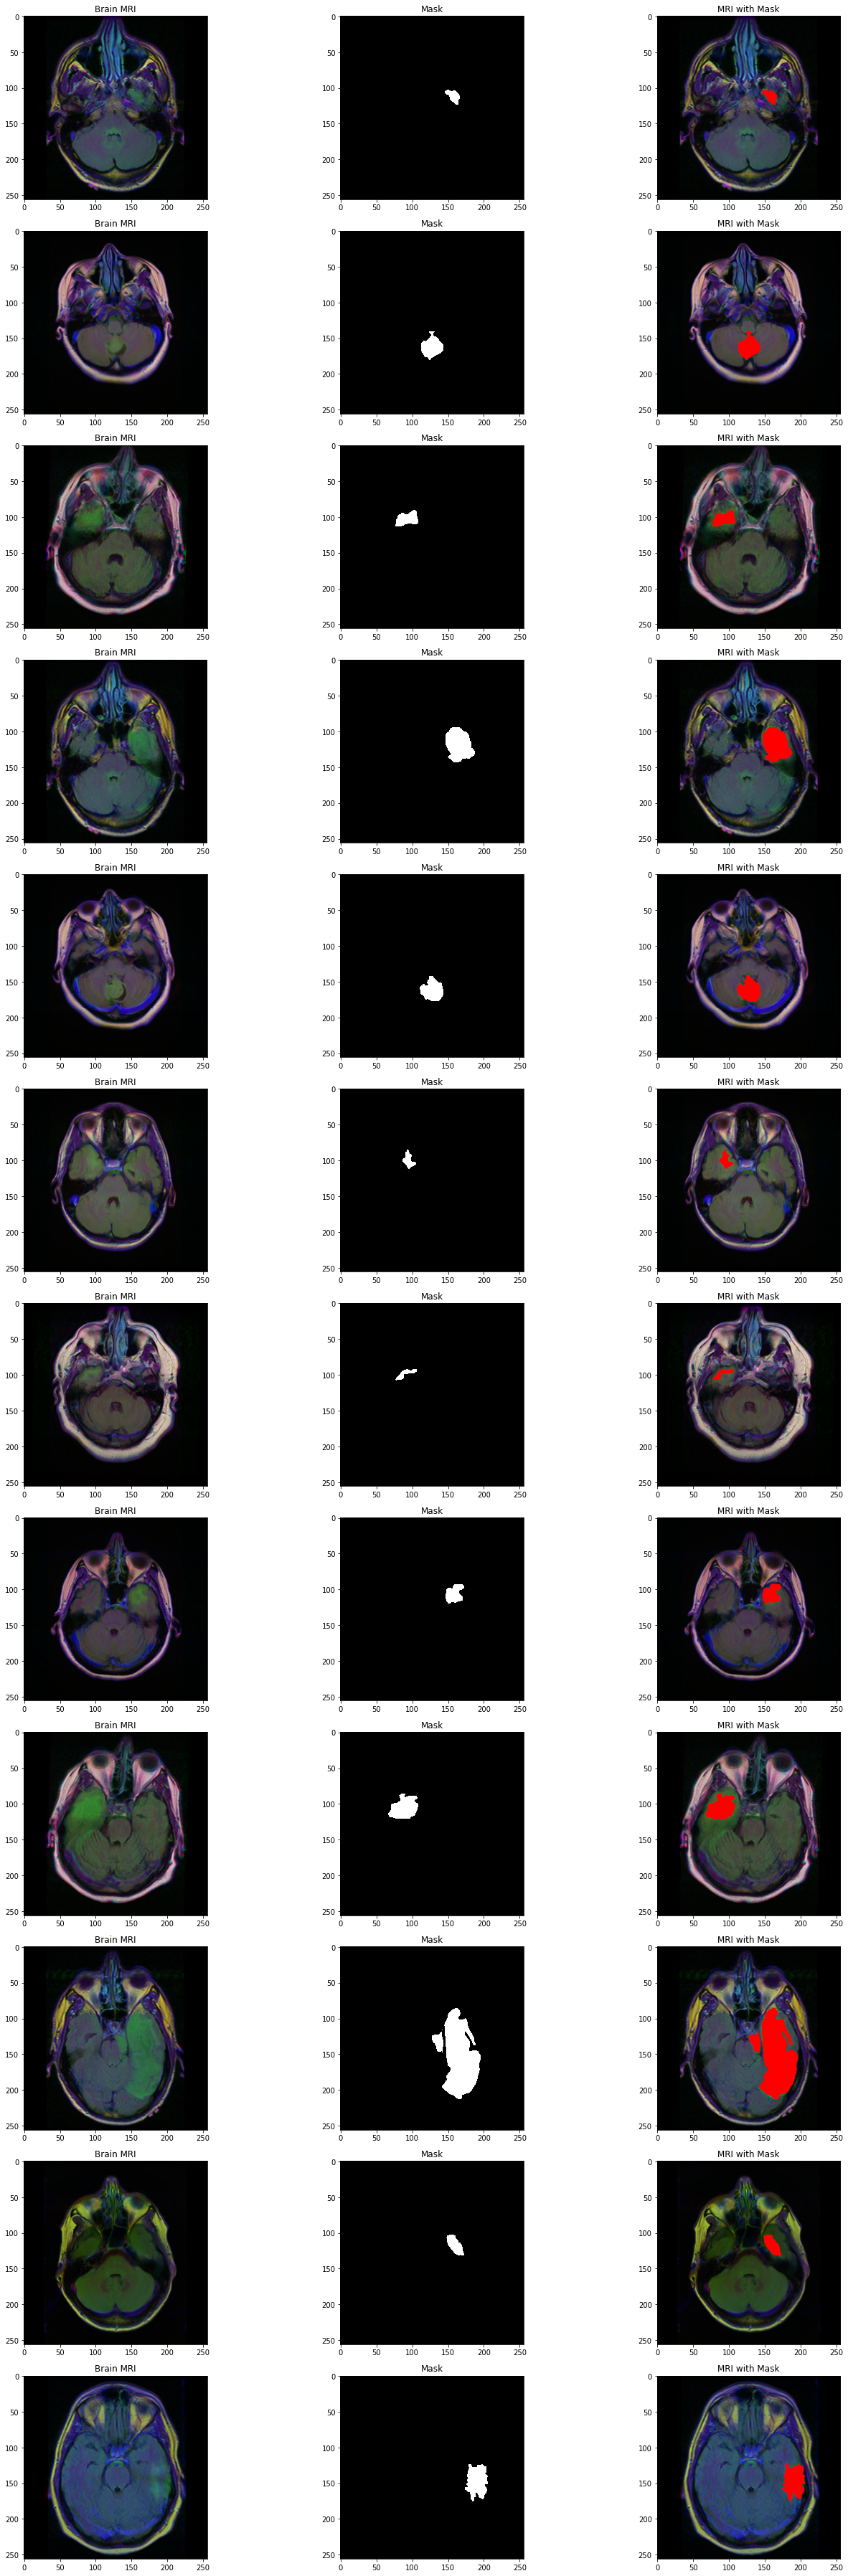

In [11]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0) # superposing mask on a brain image
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

# Train the classifier

In [12]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [13]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [14]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [15]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [16]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [17]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [18]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [19]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [21]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = tf.keras.Model(inputs = basemodel.input, outputs = headmodel)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [23]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [24]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [25]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6621
Epoch 00001: val_loss improved from inf to 12.18932, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


177/177 [==============================] - 118s 601ms/step - loss: 0.8866 - accuracy: 0.6621 - val_loss: 12.1893 - val_accuracy: 0.6351


In [26]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Asses the performance

In [27]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [28]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 8s 157ms/step


In [29]:
test_predict.shape

(576, 2)

In [30]:
test_predict

array([[5.3514354e-04, 9.9946481e-01],
       [9.9999797e-01, 2.0683437e-06],
       [9.9999118e-01, 8.7946737e-06],
       ...,
       [1.0000000e+00, 3.8405900e-13],
       [1.0000000e+00, 2.9812540e-08],
       [1.6207469e-08, 1.0000000e+00]], dtype=float32)

In [31]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [32]:
predict

array(['1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0',
       '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0',
       '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '0', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0

In [33]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [34]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9809027777777778

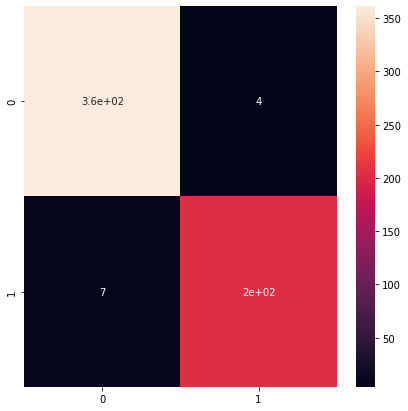

In [35]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

# ResUnet

In [37]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [38]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [39]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [40]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [41]:
def resblock(X, f):
  
  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [42]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [43]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = tf.keras.Model(inputs = X_input, outputs = output )


In [44]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

# Train ResUnet

## Loss function:

In [45]:
# Utilities file contains the code for custom loss function and custom data generator
# utilities:  https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py
from utilities import focal_tversky, tversky_loss, tversky

In [46]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [48]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

72/72 [==============================] - ETA: 0s - loss: 0.7691 - tversky: 0.2910 
Epoch 00001: val_loss improved from inf to 0.76571, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


72/72 [==============================] - 806s 11s/step - loss: 0.7691 - tversky: 0.2910 - val_loss: 0.7657 - val_tversky: 0.2990


In [49]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Asses the performance

In [50]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [51]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [52]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_14...,"[[[[1.0177848e-06], [5.596136e-06], [1.1933964...",1
1,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,No mask,0
2,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54...,No mask,0
3,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3.tif,No mask,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_5.tif,No mask,0
...,...,...,...
585,TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_1.tif,No mask,0
586,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_16...,"[[[[8.023387e-07], [3.2627422e-06], [8.532688e...",1
587,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_31...,No mask,0
588,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,"[[[[5.7137015e-07], [2.0212535e-06], [4.087563...",1


In [53]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_14...,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_14...,1,"[[[[1.0177848e-06], [5.596136e-06], [1.1933964...",1
1,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,0,No mask,0
2,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54...,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54...,0,No mask,0
3,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3.tif,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3_...,0,No mask,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_5.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_5_...,0,No mask,0


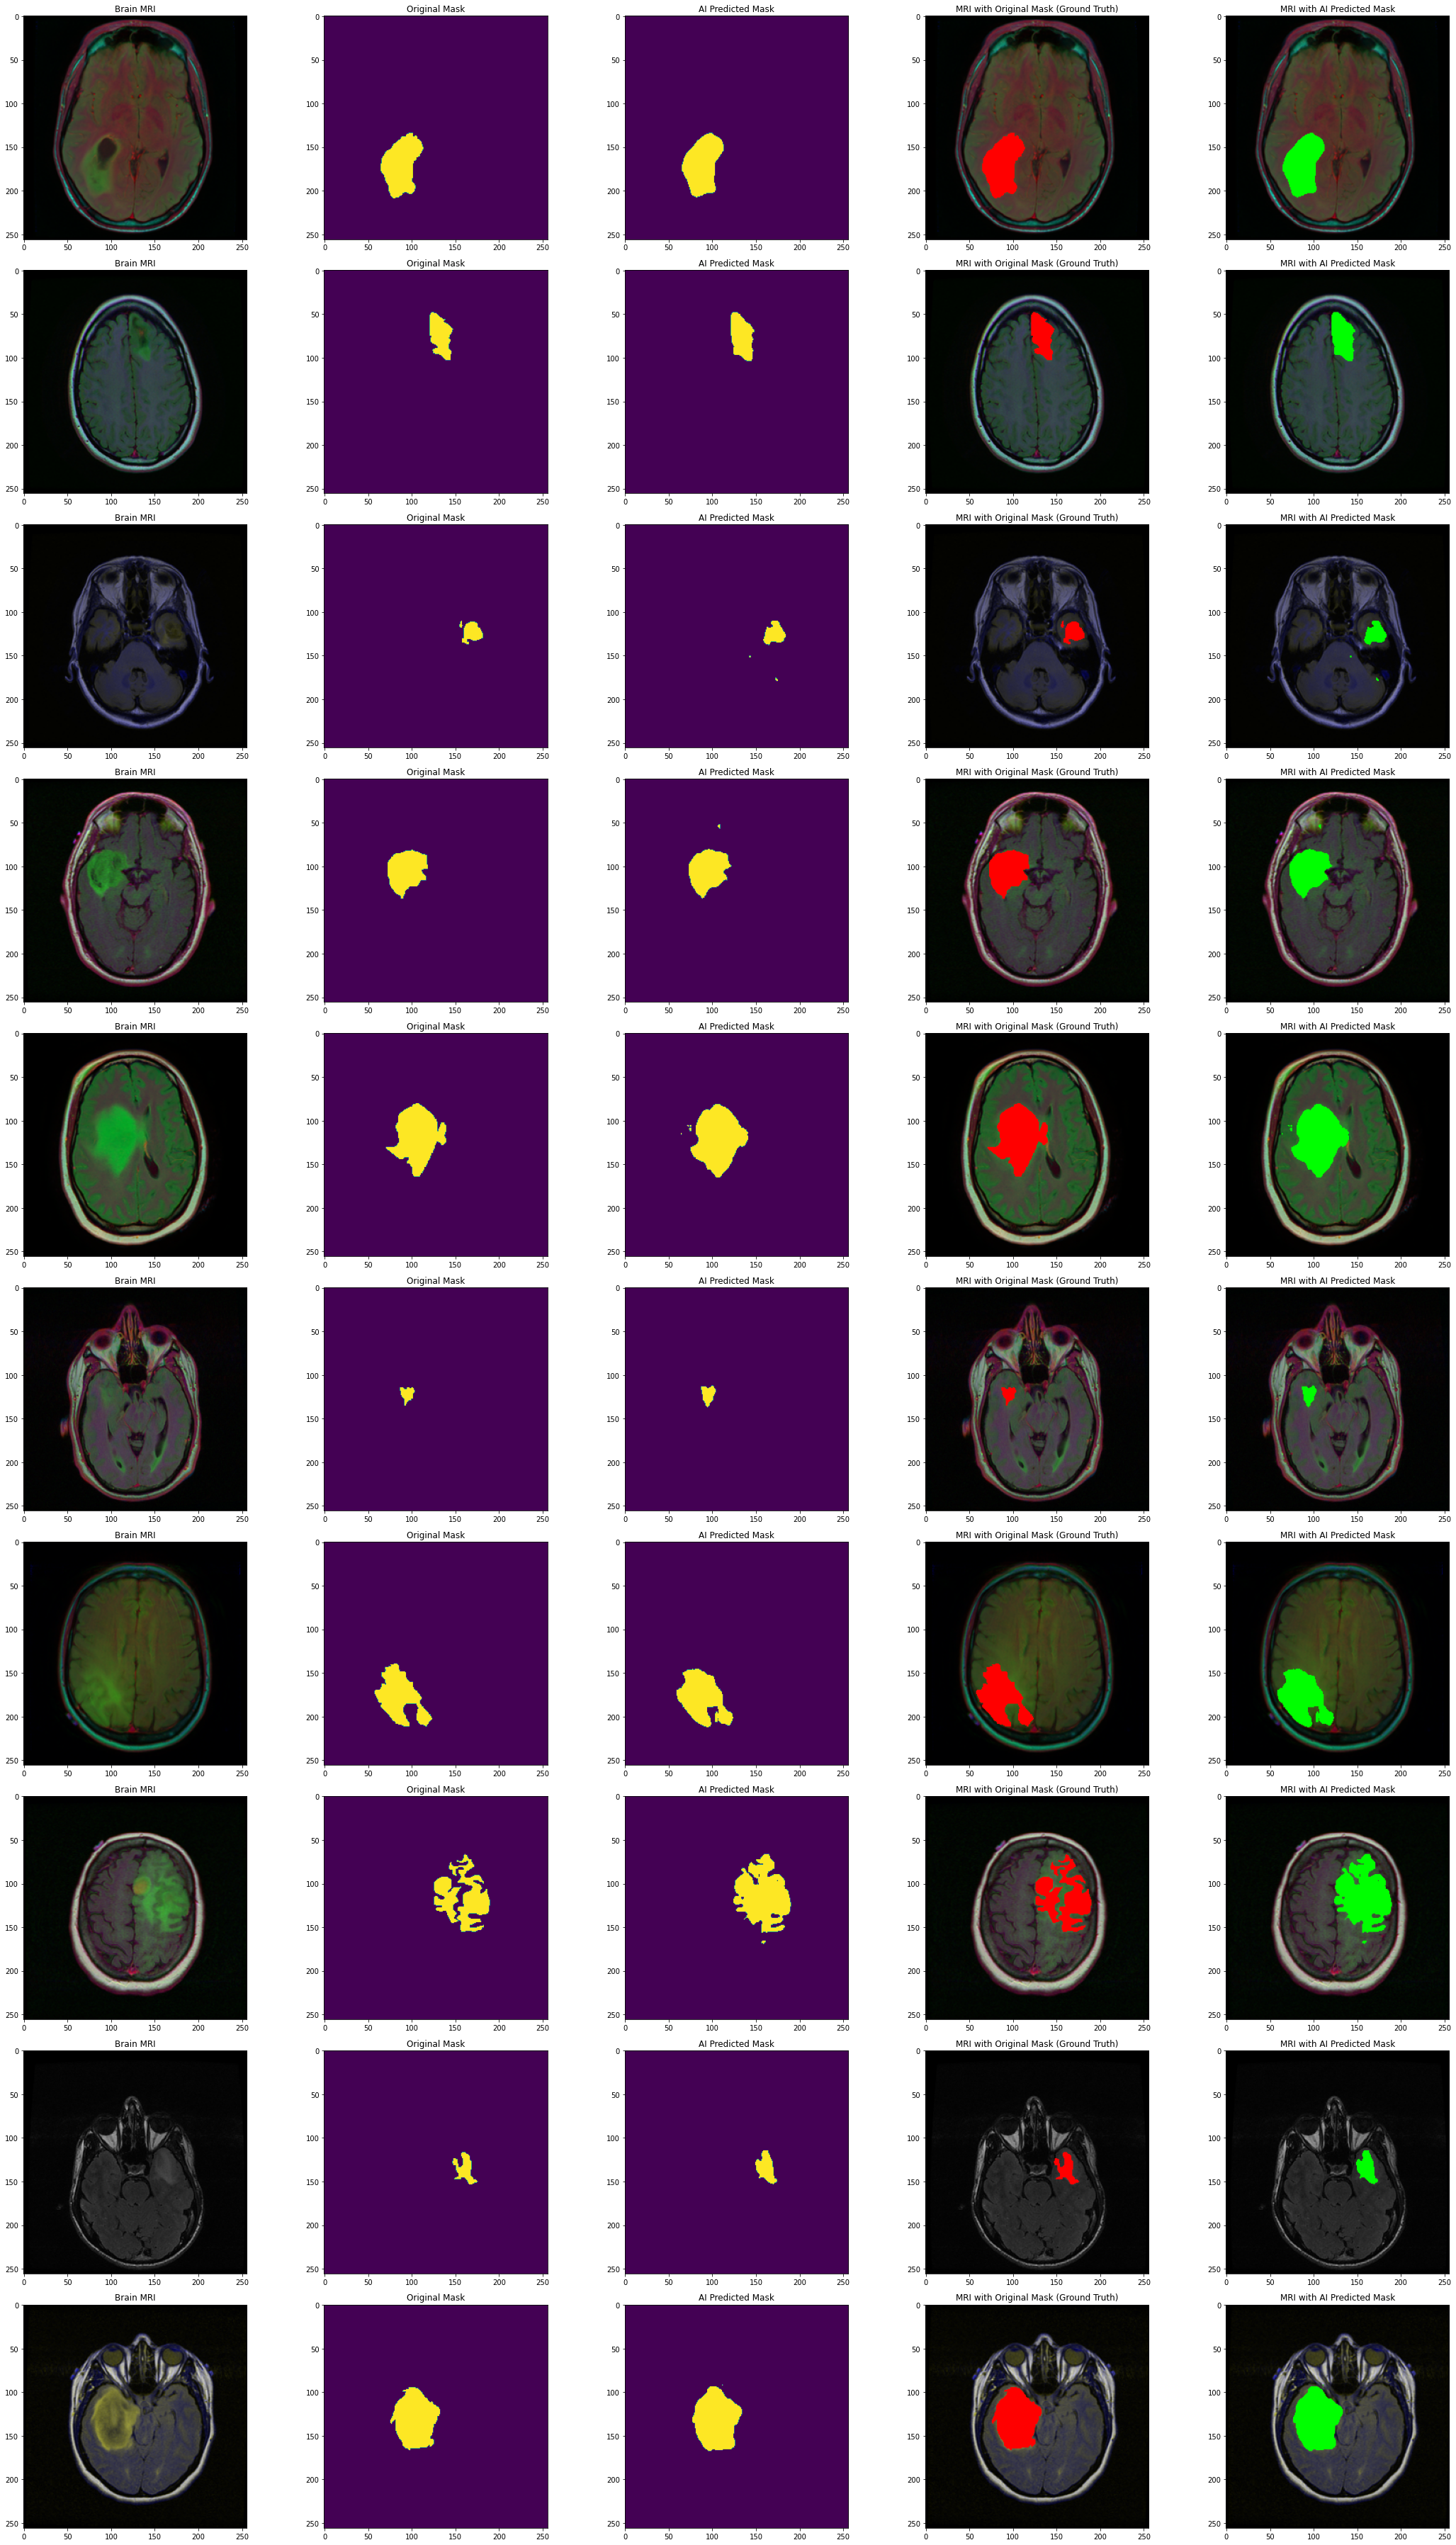

In [54]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()